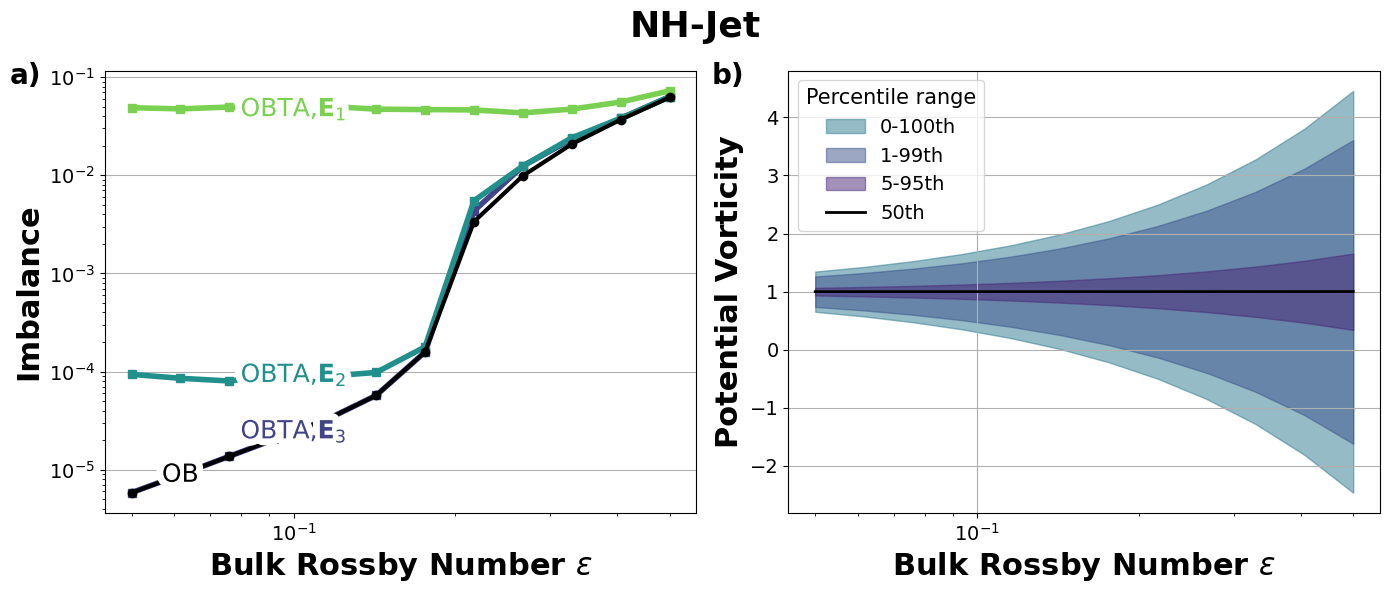

: 

In [ ]:
import fridom.nonhydro as nh
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from labellines import labelLines
from matplotlib.lines import Line2D

import obta_paper

# ================================================================
#  Compute the percentiles of the potential vorticities
# ================================================================
rossby_numbers = np.logspace(np.log10(0.05), np.log10(0.5), 12)

grid = nh.grid.cartesian.Grid(N=(2**8-1, 2**8-1, 2**6-1),
                            L=(2*np.pi, 2*np.pi, 1),
                            periodic_bounds=(True, True, False))
mset = nh.ModelSettings(grid, f0=1.0, dsqr=0.02**2).setup()

percentiles = [0, 1, 5, 50, 95, 99, 100]

min_pvs = []
for ro in rossby_numbers:
    mset.Ro = ro
    z = obta_paper.initial_conditions.NonhydroJet(mset)
    pv = z.pot_vort.unpad()
    min_pvs.append(np.percentile(pv, percentiles))
min_pvs = np.array(min_pvs)

# ================================================================
#  Plot
# ================================================================
fig, axs = plt.subplots(1, 2, figsize=(14,6), tight_layout=True)

ds = xr.load_dataset("../data/rossby_number_nh.nc", decode_timedelta=False)

colors = plt.cm.viridis_r(np.linspace(0.2, 0.8, len(ds.number_chunks)))[::-1]
labels = iter(["a)", "b)", "c)", "d)", "e)", "f)"])

# axs[0].plot(rossby_numbers, 1e-3 * rossby_numbers**2, "k--", label=r"$\epsilon^2$")

# OBTA with base point recalculation
for n_chunks, color in zip(ds.number_chunks[::-1], colors):
    ds.sel({"number_chunks": n_chunks,
            "balancing_method": "obta"}).imbalance.plot(
                ax=axs[0], marker="s", color=color, lw=4, label=f"OBTA,$\\mathbf{{E}}_{int(n_chunks)}$",
            )


# OB
ds.sel({"number_chunks":1,
        "balancing_method": "ob"}).imbalance.plot(
            ax=axs[0], marker="o", color="black", lw=3, label="OB",
        )

# Create inline labels
labelLines(axs[0].get_lines(), zorder=2.5, align=False,
        fontsize=18, outline_width=10, xvals=[0.1, 0.1, 0.1, 0.0616])


axs[0].tick_params(labelsize=14)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].grid(axis="y")
axs[0].set_xlabel(r"Bulk Rossby Number $\epsilon$", fontsize=22, fontweight="bold")
axs[0].set_ylabel("Imbalance", fontsize=22, fontweight="bold")
axs[0].set_title("")
axs[0].text(-0.16, 0.97, "a)", transform=axs[0].transAxes,
        fontsize=20, fontweight="bold")

# Potential vorticity percentiles
colors = iter(plt.cm.viridis_r(np.linspace(0.6, 0.9, 3)))
labels = ["0-100th", "1-99th", "5-95th"]

for i, (color, label) in enumerate(zip(colors, labels)):
    axs[1].fill_between(rossby_numbers, min_pvs[:, i], min_pvs[:, -i-1], alpha=0.5,
                     label=label, color=color)

axs[1].plot(rossby_numbers, min_pvs[:, 3], label="50th", color="black", lw=2)

axs[1].set_xscale("log")
axs[1].grid()
axs[1].set_ylabel("Potential Vorticity", fontsize=22, fontweight="bold")
axs[1].set_xlabel(r"Bulk Rossby Number $\epsilon$", fontsize=22, fontweight="bold")
axs[1].legend(fontsize=14, title="Percentile range", title_fontsize="15")
axs[1].tick_params(labelsize=14)
axs[1].text(-0.13, 0.97, "b)", transform=axs[1].transAxes,
        fontsize=20, fontweight="bold")

plt.suptitle("NH-Jet", fontsize=26, fontweight="bold")
plt.savefig("../figures/rossby_number_nh.png", dpi=200)